# P1: SIFT Keypoint Matching


In [ ]:
import numpy as np
import cv2
import math
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Contents of solution.py

### Discussion

##### Q1


 After several experiments, Choose the threshold to be some number around 0.7-0.75. 
When I test with the value 0.6 (given by template), there is no outliers, then 0.65: 1 outliers; 0.7: 3 outliers;
0.75: 5 outliers; 0.8: 8 outliers. As the threshold increase, the number of outliers will increase. Therefore, I choose some number
around 0.7-0.75 which will give reasonable amounts of t outliers (around3, below 10). From my understanding, as the threshold increase, 
it means the similarity between two descriptors increase. Which means the descriptor that we select may not be a good keypoint that can distinctively describe a feature,
and thus have a lower probability to be a inlier. However, if the threshold is set to be very small number, although there is no outliers, we will not have much matched pairs as well.
Therefore, after making the trade off, we can find the best threshold number is around 0.7-0.75.

##### Q2


    The effects of consistency checking:
    Use the orient_agreement and scale agreement will help us to eliminate the incorrect match (outliers). Small value of orient_agreement and scale agreement will help us eliminate large number of outliers,  but also bring small number of good matches at the same time. While as the value of orient_agreement and scale agreement increase, we will have more good matches, but also have more outliers at the same time. Therefore we need to make trade-off and find the appropriate range. After experiments (to keep the ratio threshold at 0.72), I found that the appropriate better range for orient_agreement is around [20, 55]degrees and the appropriate better range for scale_agreement is around [0.7, 0.9]. 


##### Q3
###### How does num_iter and tol contributes to the final panorama result? 
(1) according to the proportion of the outliers and sample size we choose for each iteration (in this case is 4), we can calculate that how many iterations do we need to ensure that a sample with no outliers is found(with 99% confidence). As the proportion of the outliers and the sample size increase, the number of iterations we need also increase. If we can pick the number of iterations around (or more than)the calculated result, we will get a better panorama result. For example, if we assume the proportion of the outliers is 0.5, then we at least need 75 iterations. If the number of iterations is small, we might have very distorted pictures that stitch together and may have gohst-like artifacts on the resulting image.

(2) If we set tolerance threshold to be some small number, then will help us eliminate large number of outliers,  but also bring small number of inliers  at the same time. While as the value of it increase, we will have more inliers, but also have more outliers at the same time. Therefore we need to make trade-off and find the appropriate range. If tol is not in the appropriate range, the src images in the resulting image would not in a correct position and scale



In [ ]:

def RANSACFilter(
        matched_pairs, keypoints1, keypoints2,
        orient_agreement, scale_agreement):
    """
    This function takes in `matched_pairs`, a list of matches in indices
    and return a subset of the pairs using RANSAC.
    Inputs:
        matched_pairs: a list of tuples [(i, j)],
            indicating keypoints1[i] is matched
            with keypoints2[j]
        keypoints1, 2: keypoints from image 1 and image 2
            stored in np.array with shape (num_pts, 4)
            each row: row, col, scale, orientation
        *_agreement: thresholds for defining inliers, floats
    Output:
        largest_set: the largest consensus set in [(i, j)] format

    HINTS: the "*_agreement" definitions are well-explained
           in the assignment instructions.
    """
    assert isinstance(matched_pairs, list)
    assert isinstance(keypoints1, np.ndarray)
    assert isinstance(keypoints2, np.ndarray)
    assert isinstance(orient_agreement, float)
    assert isinstance(scale_agreement, float)
    ## START

    #initialize the output array
    largest_set = []
    #convert the orient_agreement into radians
    orient_agreement = orient_agreement/180 * math.pi

    # randomly pick 10 match pair
    for x in range(10):
      #random generate index
      lenth = len(matched_pairs)
      index = np.random.randint(0,lenth)
      pair = matched_pairs[index]
      i1 = pair[0]
      i2 = pair[1]
      consistent_pair = []


      #get scale and angle difference of the initial pair
      init_scale = keypoints2[i2][2]/keypoints1[i1][2]
      init_angle = keypoints2[i2][3]-keypoints1[i1][3]

      #loop through all the pairs and find the consistent pair based on the given orient_agreement, scale_agreement
      for y in range (lenth):
        sec_pair = matched_pairs[y]
        sec_i1 = sec_pair[0]
        sec_i2 = sec_pair[1]

         #get scale and angle difference of the initial pair
        sec_scale = keypoints2[sec_i2][2]/keypoints1[sec_i1][2]
        sec_angle = keypoints2[sec_i2][3]-keypoints1[sec_i1][3]

        #calculate the scale and angle difference between the second pair and first pair
        diff_scale = abs(sec_scale - init_scale)
        diff_angle = abs(sec_angle - init_angle)

        
        #check if the difference is in the range of threshold, if it is, mark the second pair as the consistent pair and add it to the set
        if ((diff_angle <= orient_agreement) and ((diff_scale/init_scale) <= scale_agreement) ):
          consistent_pair.append(matched_pairs[y])
      
      # compare with the previous set and record the largest set
      if (len(largest_set) < len(consistent_pair)):
        largest_set = consistent_pair
        








    ## END
    assert isinstance(largest_set, list)
    return largest_set


def FindBestMatches(descriptors1, descriptors2, threshold):
       """
    This function takes in descriptors of image 1 and image 2,
    and find matches between them. See assignment instructions for details.
    Inputs:
        descriptors: a K-by-128 array, where each row gives a descriptor
        for one of the K keypoints.  The descriptor is a 1D array of 128
        values with unit length.
        threshold: the threshold for the ratio test of "the distance to the nearest"
                   divided by "the distance to the second nearest neighbour".
                   pseudocode-wise: dist[best_idx]/dist[second_idx] <= threshold
    Outputs:
        matched_pairs: a list in the form [(i, j)] where i and j means
                       descriptors1[i] is matched with descriptors2[j].
    """
    assert isinstance(descriptors1, np.ndarray)
    assert isinstance(descriptors2, np.ndarray)
    assert isinstance(threshold, float)
    ## START
   
   
    matched_pairs = []
    #get the size of the 2 descriptor arrays
    d1_size = np.shape(descriptors1)[0]
    d2_size = np.shape(descriptors2)[0]

    #loop through all the descriptor for image1, and then loop through all the descriptor for image2 to find the perfect match
    for x in range(d1_size):

      # create an array to store all the angles and then do the sort operation on it
      angles = []
      for y in range(d2_size):
        #calculate the angle between each descriptor from image1 and 2
        dot_product = np.dot(descriptors1[x], descriptors2[y])
        angle = math.acos(dot_product)
        angles.append(angle)
      
      #sort the angles and pick the smallest two
      angles_sort = sorted(angles)
      best = angles_sort[0]
      second = angles_sort[1]
      #calculate the ratio and compare it with the threshold and decide whether to pick the descritor as a good match
      #A match should be selected only if this ratio is below a threshold
      ratio = best/second
      if (ratio <= threshold):
        index = angles.index(best)
        matched_pairs.append((x,index))

      


    ## END
    return matched_pairs


def KeypointProjection(xy_points, h):
    """
    This function projects a list of points in the source image to the
    reference image using a homography matrix `h`.
    Inputs:
        xy_points: numpy array, (num_points, 2)
        h: numpy array, (3, 3), the homography matrix
    Output:
        xy_points_out: numpy array, (num_points, 2), input points in
        the reference frame.
    """
    assert isinstance(xy_points, np.ndarray)
    assert isinstance(h, np.ndarray)
    assert xy_points.shape[1] == 2
    assert h.shape == (3, 3)

    # START

    #initialize the output array
    xy_points_out = []
    #print(xy_points.shape)
    #print(xy_points[0].shape)

    #loop through the source point pairs
    for i in range(len(xy_points)):
      # first convert the 2d points to homogeneous coordinate
      a = xy_points[i]
      b=np.ones(1)
      new_point = np.hstack((a,b))

      #multiply the homography matrix `h to get project point
      project_point = np.matmul(h,new_point)
      if (project_point[2] == 0):
        project_point[2] = 1e-10

      #convert back the projected points in homogeneous coordinate
      project = project_point[:2]/project_point[[-1]]
      xy_points_out.append(project)


     



    # END
    xy_points_out = np.asarray(xy_points_out)
    return xy_points_out

def RANSACHomography(xy_src, xy_ref, num_iter, tol):
    """
    Given matches of keyponit xy coordinates, perform RANSAC to obtain
    the homography matrix. At each iteration, this function randomly
    choose 4 matches from xy_src and xy_ref.  Compute the homography matrix
    using the 4 matches.  Project all source "xy_src" keypoints to the
    reference image.  Check how many projected keyponits are within a `tol`
    radius to the coresponding xy_ref points (a.k.a. inliers).  During the
    iterations, you should keep track of the iteration that yields the largest
    inlier set. After the iterations, you should use the biggest inlier set to
    compute the final homography matrix.
    Inputs:
        xy_src: a numpy array of xy coordinates, (num_matches, 2)
        xy_ref: a numpy array of xy coordinates, (num_matches, 2)
        num_iter: number of RANSAC iterations.
        tol: float
    Outputs:
        h: The final homography matrix.
    """
    assert isinstance(xy_src, np.ndarray)
    assert isinstance(xy_ref, np.ndarray)
    assert xy_src.shape == xy_ref.shape
    assert xy_src.shape[1] == 2
    assert isinstance(num_iter, int)
    assert isinstance(tol, (int, float))
    tol = tol*1.0

    # START

    #initialize the largest consensus set
    largest = []

    # for each iteration, randomly pick 4 matches of points to compute a homography matrix.
    for i in range(num_iter):

      #randomly generate index numbers
      length = len(xy_src)
      idx = random.sample(range(0, length), 4)
      src_pts=[]
      ref_pts=[]
      #create two new point sets to contain 4 randomly selected paris
      for j in range(4):
        index = idx[j]
        src_pts.append(xy_src[index])
        ref_pts.append(xy_ref[index])

      #generate  a homography matrix
      src_pts = np.float32(src_pts).reshape(-1, 1, 2)
      ref_pts = np.float32(ref_pts).reshape(-1, 1, 2)
      h, mask = cv2.findHomography(src_pts, ref_pts, cv2.RANSAC, tol)
      h = np.asarray(h)
      
      #project all keypoints in the source image to the reference image using the computed homography matrix
      xy_points_proj = KeypointProjection(xy_src, h)

      #compute the Euclidean distance between each projected point to its correspondance in the reference frame, 
      #if the distance is within the tolerance, then add the point to the consensus set
      consensus = []
      for j in range(len(xy_points_proj)):
        distance = math.sqrt(sum((px - qx) ** 2.0 for px, qx in zip(xy_points_proj[j],xy_ref[j])))
        #distance = math.dist()
        if ( distance<= tol):
          consensus.append(j)

      #keep track of the largest consensus set
      if (len(largest)<len(consensus)):
        largest = consensus

      
    # compute and return the final homography matrix using the largest consensus set
    src_pts=[]
    ref_pts=[]
    for i in range(len(largest)):
      index = largest[i]
      src_pts.append(xy_src[index])
      ref_pts.append(xy_ref[index])
    
    src_pts = np.float32(src_pts).reshape(-1, 1, 2)
    ref_pts = np.float32(ref_pts).reshape(-1, 1, 2)
    h, mask = cv2.findHomography(src_pts, ref_pts, cv2.RANSAC, tol)
    h = np.asarray(h)






      



    # END
    assert isinstance(h, np.ndarray)
    assert h.shape == (3, 3)
    return h


def FindBestMatchesRANSAC(
        keypoints1, keypoints2,
        descriptors1, descriptors2, threshold,
        orient_agreement, scale_agreement):
    """
    Note: you do not need to change this function.
    However, we recommend you to study this function carefully
    to understand how each component interacts with each other.

    This function find the best matches between two images using RANSAC.
    Inputs:
        keypoints1, 2: keypoints from image 1 and image 2
            stored in np.array with shape (num_pts, 4)
            each row: row, col, scale, orientation
        descriptors1, 2: a K-by-128 array, where each row gives a descriptor
        for one of the K keypoints.  The descriptor is a 1D array of 128
        values with unit length.
        threshold: the threshold for the ratio test of "the distance to the nearest"
                   divided by "the distance to the second nearest neighbour".
                   pseudocode-wise: dist[best_idx]/dist[second_idx] <= threshold
        orient_agreement: in degrees, say 30 degrees.
        scale_agreement: in floating points, say 0.5
    Outputs:
        matched_pairs_ransac: a list in the form [(i, j)] where i and j means
        descriptors1[i] is matched with descriptors2[j].
    Detailed instructions are on the assignment website
    """
    orient_agreement = float(orient_agreement)
    assert isinstance(keypoints1, np.ndarray)
    assert isinstance(keypoints2, np.ndarray)
    assert isinstance(descriptors1, np.ndarray)
    assert isinstance(descriptors2, np.ndarray)
    assert isinstance(threshold, float)
    assert isinstance(orient_agreement, float)
    assert isinstance(scale_agreement, float)
    matched_pairs = FindBestMatches(
        descriptors1, descriptors2, threshold)
    matched_pairs_ransac = RANSACFilter(
        matched_pairs, keypoints1, keypoints2,
        orient_agreement, scale_agreement)
    return matched_pairs_ransac

In [ ]:
import pickle as pkl
import cv2
import numpy as np
import random
from PIL import Image, ImageDraw
import csv
import math
import matplotlib.pyplot as plt
random.seed(1)

Contents of hw_utils.py

In [ ]:
def MatchRANSAC(
        image1, image2, ratio_thres, orient_agreement, scale_agreement):
    """
    Read two images and their associated SIFT keypoints and descriptors.
    Find matches between images based on acos distance.
    Filter a subset of matches using RANSAC
    Display the final matches.
    HINT: See main_match.py on how to use this function.
    """
    im1, keypoints1, descriptors1 = ReadKeys(image1)
    im2, keypoints2, descriptors2 = ReadKeys(image2)

    keypoints1 = np.stack(keypoints1, axis=0)
    keypoints2 = np.stack(keypoints2, axis=0)
    matched_pairs = FindBestMatchesRANSAC(
        keypoints1, keypoints2,
        descriptors1, descriptors2,
        ratio_thres, orient_agreement, scale_agreement)
    matched_pairs = [
        [keypoints1[i], keypoints2[j]] for (i, j) in matched_pairs]
    assert len(matched_pairs) > 0, "No match received"
    im3 = DisplayMatches(im1, im2, matched_pairs)
    return im3


def Match(image1, image2, ratio_thres):
    """
    Read two images and their associated SIFT keypoints and descriptors.
    Find matches between images based on acos distance.
    Display the final matches.
    HINT: See main_match.py on how to use this function.
    """
    im1, keypoints1, descriptors1 = ReadKeys(image1)
    im2, keypoints2, descriptors2 = ReadKeys(image2)

    matched_pairs = FindBestMatches(
        descriptors1, descriptors2, ratio_thres)
    matched_pairs = [
        [keypoints1[i], keypoints2[j]] for (i, j) in matched_pairs]
    assert len(matched_pairs) > 0, "No match received"
    im3 = DisplayMatches(im1, im2, matched_pairs)
    return im3


def ReadKeys(image):
    """Input an image and its associated SIFT keypoints.

    The argument image is the image file name (without an extension).
    The image is read from the PGM format file image.pgm and the
    keypoints are read from the file image.key.

    ReadKeys returns the following 3 arguments:

    image: the image (in PIL 'RGB' format)

    keypoints: K-by-4 array, in which each row has the 4 values specifying
    a keypoint (row, column, scale, orientation).  The orientation
    is in the range [-PI, PI] radians.

    descriptors: a K-by-128 array, where each row gives a descriptor
    for one of the K keypoints.  The descriptor is a 1D array of 128
    values with unit length.
    """
    im = Image.open(image+'.pgm').convert('RGB')
    keypoints = []
    descriptors = []
    first = True
    with open(image+'.key','r') as f:
        reader = csv.reader(f, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC,skipinitialspace = True)
        descriptor = []
        for row in reader:
            if len(row) == 2:
                assert first, "Invalid keypoint file header."
                assert row[1] == 128, "Invalid keypoint descriptor length in header (should be 128)."
                count = row[0]
                first = False
            if len(row) == 4:
                keypoints.append(np.array(row))
            if len(row) == 20:
                descriptor += row
            if len(row) == 8:
                descriptor += row
                assert len(descriptor) == 128, "Keypoint descriptor length invalid (should be 128)."
                #normalize the key to unit length
                descriptor = np.array(descriptor)
                descriptor = descriptor / math.sqrt(np.sum(np.power(descriptor,2)))
                descriptors.append(descriptor)
                descriptor = []
    assert len(keypoints) == count, "Incorrect total number of keypoints read."
    print("Number of keypoints read:", int(count))
    descriptors = np.stack(descriptors, axis=0)
    return [im,keypoints,descriptors]


def AppendImages(im1, im2):
    """Create a new image that appends two images side-by-side.

    The arguments, im1 and im2, are PIL images of type RGB
    """
    im1cols, im1rows = im1.size
    im2cols, im2rows = im2.size
    im3 = Image.new('RGB', (im1cols+im2cols, max(im1rows,im2rows)))
    im3.paste(im1,(0,0))
    im3.paste(im2,(im1cols,0))
    return im3

def DisplayMatches(im1, im2, matched_pairs):
    """Display matches on a new image with the two input images placed side by side.

    Arguments:
     im1           1st image (in PIL 'RGB' format)
     im2           2nd image (in PIL 'RGB' format)
     matched_pairs list of matching keypoints, im1 to im2

    Displays and returns a newly created image (in PIL 'RGB' format)
    """
    im3 = AppendImages(im1,im2)
    offset = im1.size[0]
    draw = ImageDraw.Draw(im3)
    for match in matched_pairs:
        draw.line((match[0][1], match[0][0], offset+match[1][1], match[1][0]),fill="red",width=2)
    im3.show()
    return im3


def ReadData(fname):
    """
    Given the fname, return the image, keypoints, and descriptors.
    Note: the fname should be a path of the image, but with no extensions.
    For example, '/my/path/ubc.png' should be '/my/path/ubc'
    """
    with open(fname + '.pkl', 'rb') as f:
        data = pkl.load(f)
    im = Image.open(fname + '.png').convert('RGB')
    keypoints = data['keypoints']
    descriptors = data['descriptors']
    return [im, keypoints, descriptors]


def FindBestMatchesXY(im_src_path, im_ref_path, ratio_thres):
    """
    This function takes two image paths, fetch the corresponding keypoints
    of the two image paths, find the best matches between keypoints
    and return the keypoint correspondances in xy coordinates.
    Inputs:
        im_src_path: the path of the source image.
        im_ref_path: the path of the image considered as the reference frame.
        ratio_thres: threshold for ratio test.
    Outputs:
        xy_src: numpy array, (matches, 2), xy coordinates of keypoints in source.
        xy_ref: numpy array, (matches, 2), xy coordinates of keypoints in ref.
    """
    assert isinstance(im_src_path, str)
    assert isinstance(im_ref_path, str)
    assert isinstance(ratio_thres, float)
    _, keypoints1, descriptors1 = ReadData(im_src_path)
    _, keypoints2, descriptors2 = ReadData(im_ref_path)
    matches = list(FindBestMatches(descriptors1, descriptors2, ratio_thres))
    matches = [(keypoints1[i1], keypoints2[i2]) for (i1, i2) in matches]

    # Extract the xy of the matches
    yx_src, yx_ref = zip(*[(match[0][:2], match[1][:2]) for match in matches])
    xy_src = np.array(yx_src)[:, [1, 0]]  # yx to xy
    xy_ref = np.array(yx_ref)[:, [1, 0]]
    return xy_src, xy_ref


def PrepareData(image_list, ratio_thres):
    """
    This function takes in a list of image paths of interests;
    Extracts the keypoints correspondance between the reference image and all other images.
    The first image on the image_list is the reference image.
    Note: there is no RANSAC performed.
    Inputs:
        image_list: a list of paths to the images (with no extensions)
        ratio_thres: the threshold for doing the ratio test of keypoint correspondance.
    Outputs:
        xy_src_list: numpy array, (num_matches, 2)
        xy_ref_list: numpy array, (num_matches, 2)
        im_list: a list of np.array, where each np.array is an image.
    """
    assert isinstance(image_list, list)
    assert len(image_list) > 1, "Need at leat two images to do stiching"
    assert isinstance(image_list[0], str)
    assert isinstance(ratio_thres, float)
    assert ratio_thres >= 0.0
    assert ratio_thres <= 1.0

    xy_src_list = []
    xy_ref_list = []
    ref_image = image_list[0]
    image_list = image_list[1:]
    for src_image in image_list:
        xy_src, xy_ref = FindBestMatchesXY(
            src_image, ref_image, ratio_thres)
        if xy_src.shape[0] >= 4:
            xy_src_list.append(xy_src)
            xy_ref_list.append(xy_ref)

    im_ref, _, _ = ReadData(ref_image)
    im_list = [np.array(im_ref)] + [
        np.array(ReadData(img)[0]) for img in image_list]
    return xy_src_list, xy_ref_list, im_list


def MergeWarppedImages(canvas_height, canvas_width, warp_list):
    """
    Wrap a list of images in the reference frame into one canvas.
    Note:
        each image is a numpy array of shape (canvas_height, canvas_width, 3)
        The first image in the warp_list is the reference image
    """
    assert isinstance(canvas_height, int)
    assert isinstance(canvas_width, int)
    assert isinstance(warp_list, list)

    canvas = np.zeros((canvas_height, canvas_width, 3), dtype=np.uint8)

    im_ref = warp_list[0]  # reference image in reference frame
    assert im_ref.dtype == np.uint8
    canvas[:im_ref.shape[0], :im_ref.shape[1]] = im_ref
    alpha = 0.5
    for wrap in warp_list[1:]:
        assert isinstance(wrap, np.ndarray)
        assert wrap.shape == canvas.shape
        assert wrap.dtype == np.uint8
        mask_wrap = Image.fromarray(wrap).convert('L')
        mask_wrap = np.array(mask_wrap) > 0

        mask_canvas = Image.fromarray(canvas).convert('L')
        mask_canvas = np.array(mask_canvas) > 0

        mask_intersect = np.logical_and(mask_canvas, mask_wrap)

        # blend in intersected area
        canvas[mask_intersect] = (
                alpha*canvas[mask_intersect] +
                (1-alpha)*wrap[mask_intersect]).astype(np.uint8)
        canvas[mask_intersect] = (
                alpha*canvas[mask_intersect] +
                (1-alpha)*wrap[mask_intersect]).astype(np.uint8)

        # copy in non-interected area
        mask_empty = np.logical_not(mask_intersect)
        canvas[mask_empty] += wrap[mask_empty]
    return canvas


def ProjectImages(
        xy_src_list, xy_ref_list, im_list,
        canvas_height, canvas_width, num_iter, tol):
    """
    This function takes in a list of images, and the points correspondance between
    the reference image and other images; computes the homography from every source
    image to the reference image using RANSAC; warp each source image to the reference
    image frame using each homography computed.
    Inputs:
        xy_src_list: a list of np array, each element is keypoint correspondance
                     between a source image to the reference image, in xy coordinates.
        xy_ref_list: a list of np array, each element is keypoint correspondance
                     between a source image to the reference image, in xy coordinates.
        im_list: all images in np.array form, the firs element is the reference image.
        canvas_height, canvas_width: the dimension of the canvas to copy the warps over.
        num_iter: number of RANSAC iterations in RANSACHomography
        tol: the Euclidean tolerance for keypoints matching projection.
    Outputs:
        A list of images in np.array form after they have been projected to
        the reference frame.
    """
    assert isinstance(xy_src_list, list)
    assert isinstance(xy_ref_list, list)
    assert isinstance(im_list, list)
    assert isinstance(canvas_height, int)
    assert isinstance(canvas_width, int)
    assert isinstance(num_iter, int)
    assert isinstance(tol, (int, float))
    assert len(xy_src_list) == len(xy_ref_list)
    assert len(xy_src_list) + 1 == len(im_list), \
        "Num of source images + 1 == num of all images"

    homo_list = []
    for xy_src, xy_ref in zip(xy_src_list, xy_ref_list):
        h = RANSACHomography(xy_src, xy_ref, num_iter, tol)
        homo_list.append(h)
    warp_list = [im_list[0]]
    im_list = im_list[1:]
    assert len(im_list) == len(homo_list)
    for im, h in zip(im_list, homo_list):
        result = cv2.warpPerspective(im, h, (canvas_width, canvas_height))
        warp_list.append(result)
    return warp_list


def VisualizePointProj(xy_src, xy_ref, xy_proj, im_src, im_ref):
    assert isinstance(xy_src, np.ndarray)
    assert isinstance(xy_ref, np.ndarray)
    assert isinstance(xy_proj, np.ndarray)
    assert isinstance(im_src, np.ndarray)
    assert isinstance(im_ref, np.ndarray)
    assert xy_src.shape == xy_ref.shape
    assert xy_src.shape == xy_proj.shape

    fig, axes = plt.subplots(
        1, 2, figsize=(30, 30), gridspec_kw={'width_ratios': [1, 2]})
    for xy_a, xy_b in zip(xy_proj, xy_ref):
        x1, y1 = xy_a
        x2, y2 = xy_b
        axes[1].plot([x1, x2],[y1, y2], 'w-', linewidth=2)

    axes[0].imshow(im_src)
    axes[0].scatter(xy_src[:, 0], xy_src[:, 1], c='#fafba4', s=100, marker='.')
    axes[0].title.set_text('Source Image')

    axes[1].imshow(im_ref)
    axes[1].scatter(xy_proj[:, 0], xy_proj[:, 1], c='#fafba4', s=100, marker='.')
    axes[1].scatter(xy_ref[:, 0], xy_ref[:, 1], c='#d63447', s=100, marker='.')
    axes[1].title.set_text('Reference Image')
    fig.show()
    input('Press any key to exit the program')


This sample program loads two images and their invariant keypoints and then draws 5 lines between randomly selected keypoints to show how matches can be displayed. Your task is to improve this program so that it identifies and displays correct matches by comparing the keypoint descriptor vectors. Note: Your program should find all possible matches, not just 5 as shown in this sample.

In [ ]:
import matplotlib.pyplot as plt

Contents of main_match.py

Number of keypoints read: 694
Number of keypoints read: 579
Number of keypoints read: 1766
Number of keypoints read: 849


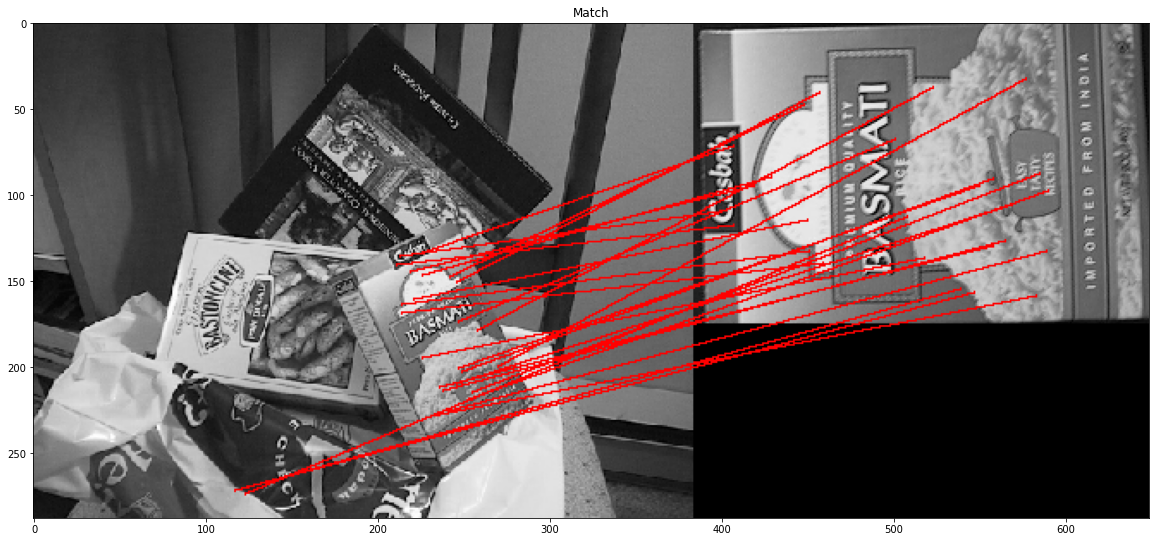

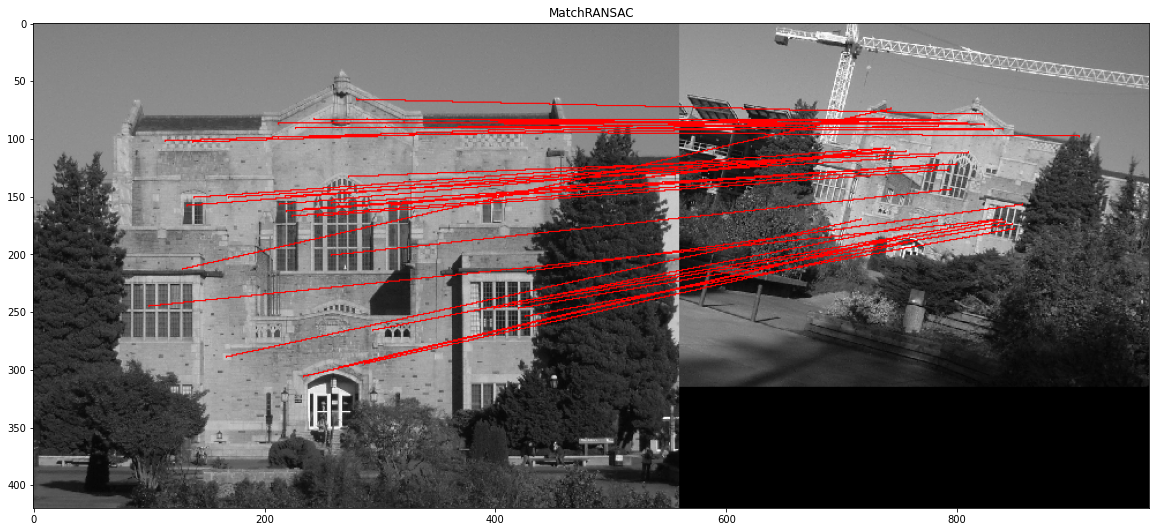

In [ ]:
""" After several experiments, Choose the threshold to be some number around 0.7-0.75. 
When I test with the value 0.6 (given by template), there is no outliers, then 0.65: 1 outliers; 0.7: 3 outliers;
0.75: 5 outliers; 0.8: 8 outliers. As the threshold increase, the number of outliers will increase. Therefore, I choose some number
around 0.7-0.75 which will give reasonable amounts of t outliers (around3, below 10). From my understanding, as the threshold increase, 
it means the similarity between two descriptors increase. Which means the descriptor that we select may not be a good keypoint that can distinctively describe a feature,
and thus have a lower probability to be a inlier. However, if the threshold is set to be very small number, although there is no outliers, we will not have much matched pairs as well.
Therefore, after making the trade off, we can find the best threshold number is around 0.7-0.75.
 """
# Test run matching with no ransac
plt.figure(figsize=(20, 20))
im = Match('/content/drive/MyDrive/cs425/hw4/data/scene', '/content/drive/MyDrive/cs425/hw4/data/basmati', 0.72)
plt.title('Match')
plt.imshow(im)
im.save('findBestMatch.jpg')
# Test run matching with ransac
plt.figure(figsize=(20, 20))
im = MatchRANSAC(
    '/content/drive/MyDrive/cs425/hw4/data/library', '/content/drive/MyDrive/cs425/hw4/data/library2',
    ratio_thres=0.72, orient_agreement=25, scale_agreement=0.75)
plt.title('MatchRANSAC')
plt.imshow(im)
im.save('findBestMatchRANSAC.jpg')

# P2: Panorama

In [ ]:
import os.path as op

Contents of test_pano.py

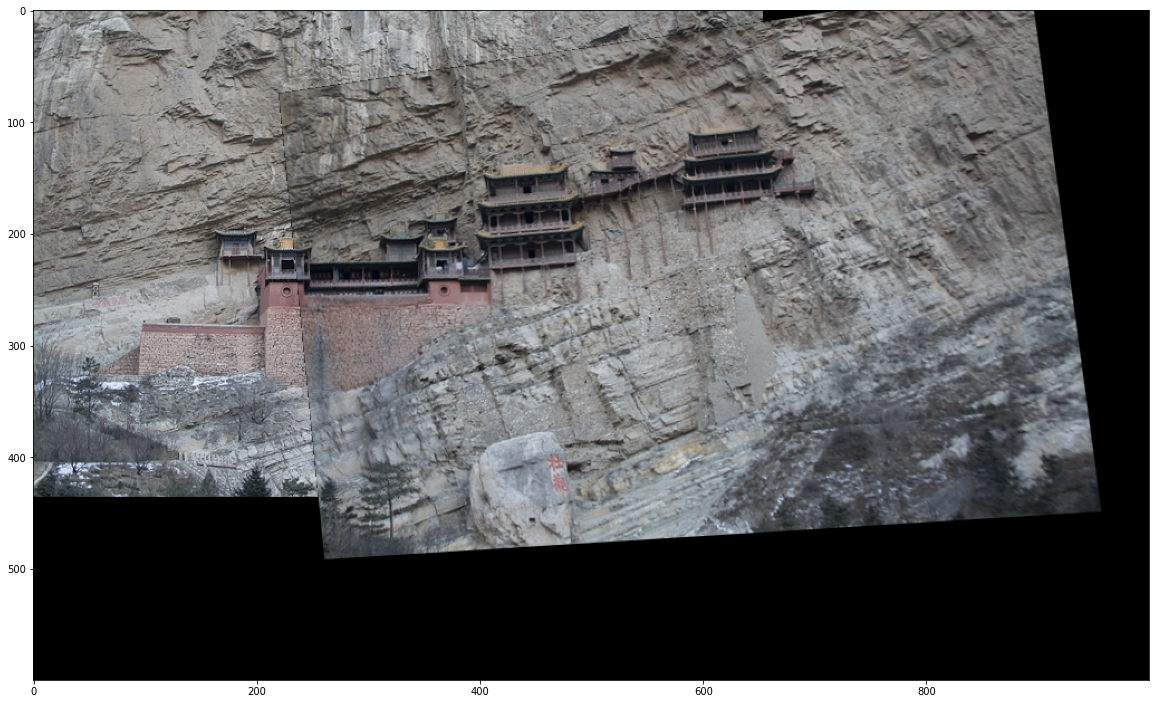

In [ ]:
path = '/content/drive/MyDrive/cs425/hw4/data/'
image_list = ['Hanging1', 'Hanging2']
image_list = [op.join(path, im) for im in image_list]
# the dimension of the canvas (numpy array)
# to which we are copying images.
canvas_width = 1000
canvas_height = 600

# some precomputed data for sanity check
with open('/content/drive/MyDrive/cs425/hw4/data/test.pkl', 'rb') as f:
    test_dict = pkl.load(f)
h_gt = test_dict['h']  # the homograph matrix we computed

# matches between the source and the refence image
xy_src = test_dict['xy_src']  # (match, 2)
xy_ref = test_dict['xy_ref']  # (match, 2)

# image_list should store both the reference and the source images
ref_image = image_list[0]  # first element is the reference image
source_image = image_list[1]

# compute the homography matrix to transform the source to the reference
h, _ = cv2.findHomography(xy_src, xy_ref)

# The current computed value should equal to our precomputed one
norm_diff = ((h-h_gt)**2).sum()
assert norm_diff < 1e-7, 'The computed homography matrix should equal to the given one.'

# read the two images as numpy arrays
im_src = np.array(ReadData(source_image)[0])
im_ref = np.array(ReadData(ref_image)[0])

# project source image to the reference image using the homography matrix
# the size of canvas is specified to store all images after projections.
im_src_warp = cv2.warpPerspective(im_src, h, (canvas_width, canvas_height))

# warp_list should contain all images, where the first
# element is the reference image
warp_list = [im_ref, im_src_warp]
result = MergeWarppedImages(canvas_height, canvas_width, warp_list)

# plot the result of the warping
plt.figure(figsize=(20, 20))
plt.imshow(result)
plt.show()

In [ ]:
import sys

Contents of main_proj.py

In [ ]:
with open('/content/drive/MyDrive/cs425/hw4/data/test.pkl', 'rb') as f:
    test_dict = pkl.load(f)

# visualize 30 random matches
num_pts = 30
idx = np.random.permutation(test_dict['xy_src'].shape[0])[:num_pts]
xy_src = test_dict['xy_src'][idx]
xy_ref = test_dict['xy_ref'][idx]
h = test_dict['h']

# project the src keypoints to the reference frame using homography
xy_proj = KeypointProjection(xy_src, h)

# visualize the results
im_ref = np.array(Image.open('/content/drive/MyDrive/cs425/hw4/data/Hanging1.png'))
im_src = np.array(Image.open('/content/drive/MyDrive/cs425/hw4/data/Hanging2.png'))
VisualizePointProj(xy_src, xy_ref, xy_proj, im_src, im_ref)

Output hidden; open in https://colab.research.google.com to view.

Contents of main_pano.py

In [ ]:
def create_pano(
        image_list, ratio_thres,
        canvas_height, canvas_width,
        num_iter, tol, figsize=(20, 20)):
    """
    This function creates a panorama using a list of images.
    Inputs:
        image_list: a list of str, the path to each image (without file extensions).
        ratio_thres: the ratio test threshold in `FindBestMatches`
        canvas_height, canvas_width: The dimension of the canvas
        num_iter: num of iterations of performing RANSAC to find the homography matrix.
        tol: tolerance for keypoint projection
    """
    # Get the matches from `FindBestMatches`
    # xy_src_list: np.array, (matches, 2) in xy format
    # xy_ref_list: np.array, (matches, 2) in xy format
    # im_list: a list of images in np.array
    xy_src_list, xy_ref_list, im_list = PrepareData(
        image_list, ratio_thres)

    # Use the matches to estimate a homography matrix to the ref image frame
    # for each source image. Then project each source image to the reference
    # frame using the homography matrix.
    wrap_list = ProjectImages(
        xy_src_list, xy_ref_list, im_list,
        canvas_height, canvas_width, num_iter, tol)

    # Merge the projected images above
    # Note: the first element is the reference image in warp_list
    result = MergeWarppedImages(
        canvas_height, canvas_width, wrap_list)

    # show the final panorama
    plt.figure(figsize=figsize)
    plt.imshow(result)
    plt.show()
    return result

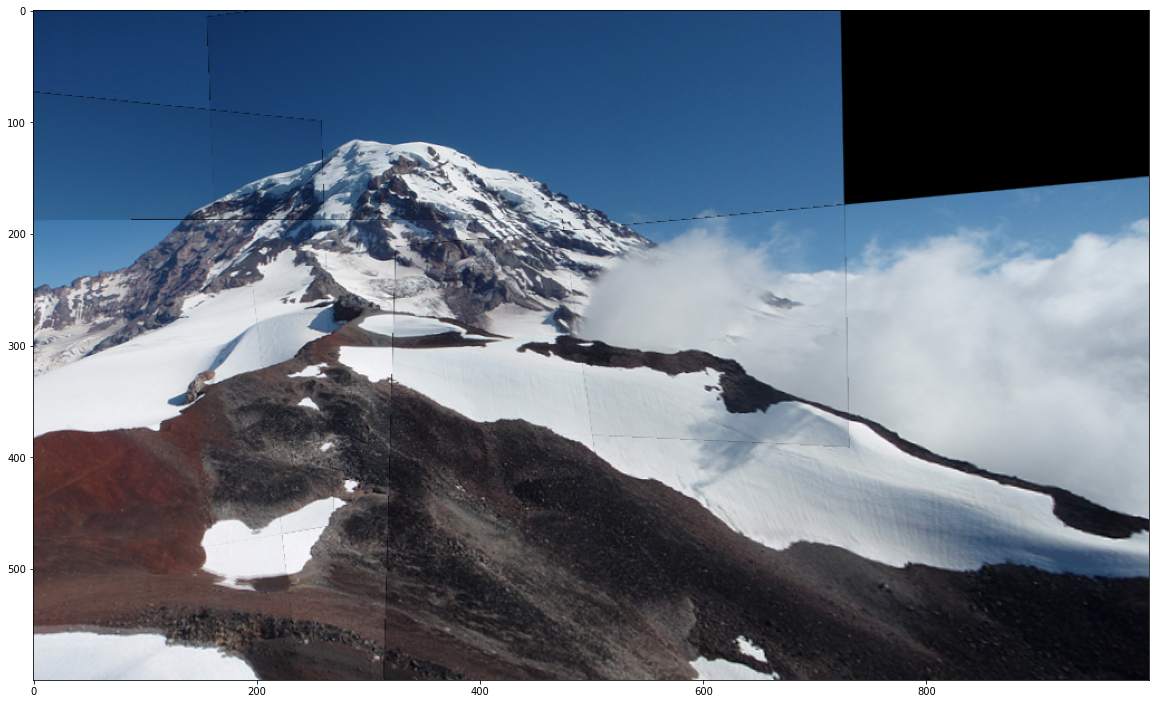

In [ ]:
path = '/content/drive/MyDrive/cs425/hw4/data/'

canvas_height = 600
canvas_width = 1000
image_list = ['Rainier1', 'Rainier2', 'Rainier3','Rainier4','Rainier5','Rainier6']

num_iter = 75
tol = 5
ratio_thres = 0.9
image_list = [op.join(path, im) for im in image_list]
im = create_pano(image_list, ratio_thres, canvas_height, canvas_width,
            num_iter, tol, figsize=(20, 20))


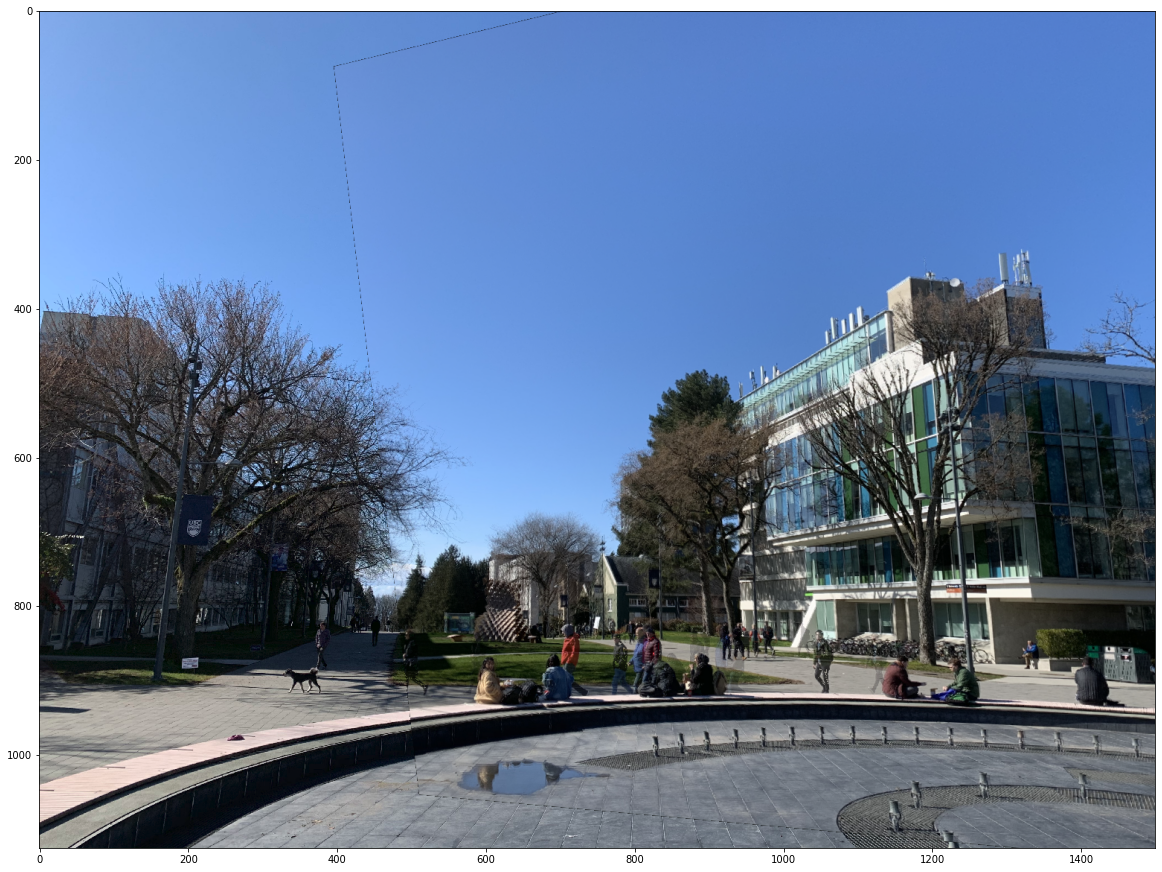

In [ ]:

canvas_height = 1125
canvas_width = 1500
image_list = ['fountain4', 'fountain0']

num_iter = 75
tol = 15
ratio_thres = 0.9
image_list = [op.join(path, im) for im in image_list]
im = create_pano(image_list, ratio_thres, canvas_height, canvas_width,
            num_iter, tol, figsize=(20, 20))


In [ ]:
canvas_height = 1125
canvas_width = 1500
image_list = ['garden0', 'garden3','garden4']

num_iter = 150
tol = 5
ratio_thres = 0.8
image_list = [op.join(path, im) for im in image_list]
im = create_pano(image_list, ratio_thres, canvas_height, canvas_width,
            num_iter, tol, figsize=(20, 20))

Output hidden; open in https://colab.research.google.com to view.

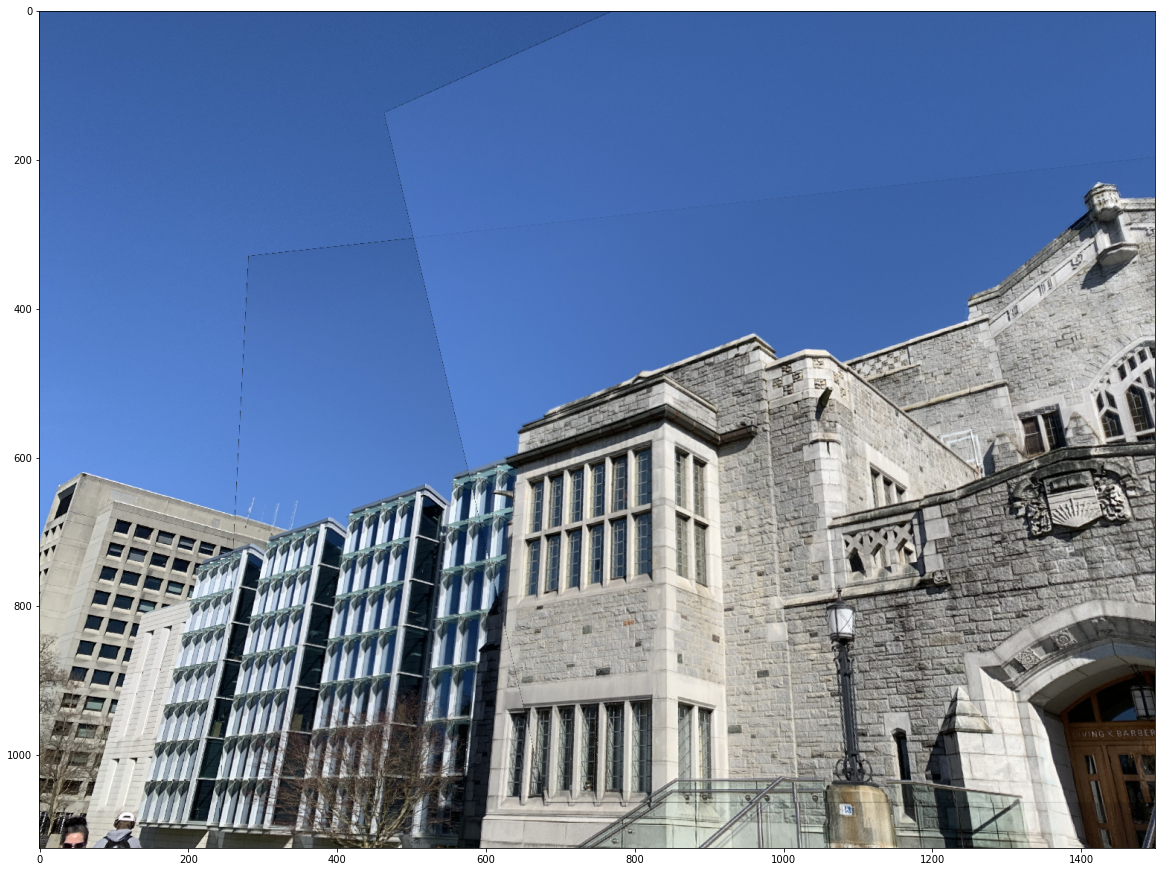

In [ ]:
canvas_height = 1125
canvas_width = 1500
image_list = ['irving_out3', 'irving_out6','irving_out5']

num_iter = 100
tol = 5
ratio_thres = 0.72
image_list = [op.join(path, im) for im in image_list]
im = create_pano(image_list, ratio_thres, canvas_height, canvas_width,
            num_iter, tol, figsize=(20, 20))
